# HSE-2024 text classification project

## Table of content
* [Imports](#c1)
* [Data loading and preprocessing](#c2)
* [Custom dataset](#c3)
* [Custom model](#c4)
* [Trainer](#c5)
* [Model training](#c6)

### Imports <a class="anchor" id="c1"></a>

In [1]:
import numpy as np
import pandas as pd

import torch
from sklearn.model_selection import train_test_split

import os
import re
import string

from classes import Preprocessor, MyModel, Trainer

### Data loading and preprocessing <a class="anchor" id="c2"></a>

In [2]:
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)

In [3]:
base_dir = 'data/'
if not os.path.exists(base_dir):  # создадим папку, куда будем сохранять модели, и где будут лежать данные
    os.makedirs(base_dir)

In [4]:
texts = pd.read_csv(f'{base_dir}texts_and_metadata.txt', sep='\t')
texts.sample(3)

,document.id,source,stage,source_text,lemm_text,city,region,date
10406,893760058,iqbuzz,3,"[[id32343424|Саша], русские - не национальност...",саша русский национальность русский принадлежн...,Санкт-Петербург,Санкт-Петербург,2015-05-11
7775,762822458,iqbuzz,3,"[[id222274682|Радиостанция], просто в тут в до...",радиостанция просто дом студент мент абхаз час...,Ставрополь,Ставропольский край,2015-02-16
12655,517943,vk,1,Владимир Путин по-прежнему пользуется поддержк...,владимир путин по-прежнему пользоваться поддер...,Самара,Самарская область,2011-12-25


In [5]:
data = pd.read_csv(f'{base_dir}coding_results.txt', low_memory=False, sep='\t')
data.sample(3)

,document.id,source,stage,data,assessor,seed_eth_group,for_questions_about_text,do_text_make_sense_raw,do_text_make_sense_recoded,has_ethnonym_raw,...,represent_ethicity_raw,represent_ethicity_meaning,is_ethicity_superior_raw,is_ethicity_superior_meaning,is_ethicity_aggressor_raw,is_ethicity_aggressor_meaning,is_ethicity_dangerous_raw,is_ethicity_dangerous_meaning,comment,old_id
76359,890832326,iqbuzz,2,2016-09-22 15:40:03,adzhigitova,туркмен,0,yes,1,several,...,2.0,unk,2.0,high,3.0,irrel,1.0,no,NaN,туркмен_17
23159,770545957,iqbuzz,3,2017-03-25 16:40:23,adzhigitova,украинец,1,yes,1,several,...,3.0,yes,3.0,irrel,1.0,victim,1.0,no,другое - русскоговорящие|,770545957
65036,775296209,iqbuzz,2,2016-09-21 17:06:51,skuchilina,карачаевец,0,yes,1,several,...,1.0,no,3.0,irrel,1.0,victim,1.0,no,NaN,карачаевец_92


In [6]:
df = texts.merge(data, how='left')
df.sample(5)

,document.id,source,stage,source_text,lemm_text,city,region,date,data,assessor,...,represent_ethicity_raw,represent_ethicity_meaning,is_ethicity_superior_raw,is_ethicity_superior_meaning,is_ethicity_aggressor_raw,is_ethicity_aggressor_meaning,is_ethicity_dangerous_raw,is_ethicity_dangerous_meaning,comment,old_id
72917,1007177337,iqbuzz,3,"[[id139985613|Dima], Лавров наполовину,Сечин ,...",dima лавров путин медведев русский хоть родить...,Великие Луки,Псковская область,2015-08-26,2017-03-31 12:44:34,an_men,...,1.0,no,1.0,low,3.0,irrel,1.0,no,"перечисление:'индусы,монголы,вьетнамцы,ацтеки'",1007177337
72044,989379841,iqbuzz,3,"[[id218009332|Джамбулат], то что ссылали Карач...",джамбулат ссылать знать однако крымский татари...,Махачкала,Дагестан,2015-08-09,2017-03-31 20:34:34,Tatiana,...,1.0,no,3.0,irrel,1.0,victim,1.0,no,крымские татары,989379841
31650,821824558,iqbuzz,2,"[[id135780810|Стас], зато у тебя в городе разв...",стас зато город развлекательный центр ресторан...,Калуга,Калужская область,2015-03-22,2016-09-25 01:02:39,adzhigitova,...,1.0,no,1.0,low,3.0,irrel,2.0,yes,другой = хохлы,чучмек_27
67998,926075267,iqbuzz,3,Что за бред.. Путину прям делать нечего больше...,путин прям делать нечего большой мериться блин...,Апатиты,Мурманская область,2015-06-04,2017-03-18 11:26:34,DariaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,926075267
41584,714860741,iqbuzz,3,= = В Латвии запретили прилюдно говорить не по...,латвия запретить прилюдно говорить центр госяз...,Санкт-Петербург,Санкт-Петербург,2015-01-20,2017-03-31 19:23:36,belchonok,...,1.0,no,3.0,irrel,1.0,victim,1.0,no,NaN,714860741


In [7]:
df.shape

(84784, 61)

In [8]:
df['do_text_make_sense_raw'].value_counts()

do_text_make_sense_raw
yes     78372
no       4334
lang     1890
joke      188
Name: count, dtype: int64

In [9]:
df.drop(df[df['do_text_make_sense_raw'] == 'no'].index, inplace=True)

In [10]:
ops = ['is_text_positive_recoded', 'is_text_neg_recoded']
df[ops] = df[ops].apply(pd.to_numeric, errors='coerce')
pos_ = df['is_text_positive_recoded']
neg_ = df['is_text_neg_recoded']
df.loc[(pos_ > 0) & (neg_ < 0), ops] = None
df.loc[neg_ < 0, 'text_sentiment'] = -1
df.loc[pos_ > 0, 'text_sentiment'] = 1
df.loc[(neg_ == 0) & (pos_ == 0), 'text_sentiment'] = 0

In [11]:
args = ['text_sentiment', 'has_eth_conflict_raw', 'has_pos_eth_interaction_raw', 'opinion_about_ethnonym_recoded',
        'is_ethicity_superior_meaning', 'is_ethicity_aggressor_meaning',
        'is_ethicity_dangerous_meaning']
MAX_SPOIL = len(args)
topic_to_russian = {'culture': 'культура', 'economics': 'экономика', 'ethicity': 'этничность', 'history': 'история',
                    'humour': 'юмор', 'daily_routine': 'рутина', 'migration': 'миграция', 'other': 'другая',
                    'politics': 'политика', 'religion': 'религия', 'society_social': 'социальная'}
MAX_SPOIL

7

In [12]:
df['has_pos_eth_interaction_raw'].value_counts()

has_pos_eth_interaction_raw
no     62783
yes    13603
unk     1986
Name: count, dtype: int64

In [13]:
var_vocab = {
    'text_sentiment': {'labels': {-1.0: 'этот текст является негативным', 0: 'этот текст является нейтральным',
                                  1.0: 'этот текст является позитивным'}, 'aspect_level': False, 'prompt': 'тональность текста'},
    'has_eth_conflict_raw': {
        'labels': {'yes': 'в тексте есть этнический конфликт', 'no': 'в тексте этнический конфликт отсутствует',
                   'unk': None},
        'aspect_level': False, 'prompt': 'оцени наличие этнического конфликта'},
    'has_pos_eth_interaction_raw': {'labels': {'yes': 'в тексте есть позитивное взаимодействие между этичностями',
                                               'no': 'в тексте не зафиксировано позитивного взаимодействия этичностей',
                                               'unk': None},
                                    'aspect_level': False, 'prompt': 'наличие позитивного взаимодействия этничностей'},
    'opinion_about_ethnonym_recoded': {'labels': {-1: 'мнение об этничности \'{}\' отрицательное',
                                                  0: 'мнение об этничности \'{}\' нейтральное или не зафиксировано',
                                                  1: 'мнение об этничности \'{}\' положительное'},
                                       'aspect_level': True, 'prompt': 'мнение о {} в тексте'},
    # 'represent_ethicity_meaning': {'labels': {}, 'aspect_level': True}, # not using yet
    'is_ethicity_superior_meaning': {'labels': {'high': 'этничность \'{}\' является доминирующей',
                                                'low': 'этничность \'{}\' является отчасти доминирующей',
                                                'irrel': None},
                                     'aspect_level': True, 'prompt': 'является ли этничность {} доминирующей'},
    'is_ethicity_aggressor_meaning': {'labels': {'agressor':
                                                     'этничность \'{}\' является агрессором',
                                                 'victim': 'этничность \'{}\' является жертвой',
                                                 'irrel': None},
                                      'aspect_level': True, 'prompt': 'является ли этничность {} агрессором'},
    'is_ethicity_dangerous_meaning': {
        'labels': {'yes': 'этничность \'{}\' является опасной',
                   'no': 'этничность \'{}\' не является опасной',
                   'irrel': None},
        'aspect_level': True, 'prompt': 'является ли этничность {} опасной'},
}

In [14]:
df = df.fillna(np.nan).replace([np.nan], [None])

In [15]:
ids = df['document.id'].unique()
ids.shape  # 14196 после дропа по do_text_make_sence = no

(14196,)

In [16]:
def clean(text):
    text = text.apply(lambda x: str(x))
    CLEANR = [re.compile('<.*?>'), re.compile("\[.*?\]")]
    for i in CLEANR:
        text = text.apply(lambda x: re.sub(i, '', x))
    text = text.apply(lambda x: x.replace('\\', ''))
    text = text.apply(lambda x: re.sub(r"([" + re.escape(string.punctuation) + r"])\1+", r"\1", x))
    text = text.apply(lambda x: re.sub(r"http\S+", '', x))
    text = text.apply(lambda x: re.sub(r"\r", '', x))
    text = text.apply(lambda x: re.sub(r'\s+', ' ', x))
    text = text.apply(lambda x: re.sub(r'\s+', ' ', x))
    text = text.apply(lambda x: re.sub('"+','"', x))
    text = text.apply(lambda x: re.sub("'+","'", x))
    items = string.punctuation + " "
    text = text.apply(lambda x: x.lstrip(items) if isinstance(x, str) else x)
    return text

<>:3: SyntaxWarning: invalid escape sequence '\['
<>:3: SyntaxWarning: invalid escape sequence '\['
C:\Users\bentodan\AppData\Local\Temp\ipykernel_15064\3087058704.py:3: SyntaxWarning: invalid escape sequence '\['
  CLEANR = [re.compile('<.*?>'), re.compile("\[.*?\]")]


In [17]:
df['source_text'] = clean(df['source_text'])

In [18]:
df['source_text'][0]

'но у вас же бред написан. Какими русскими? Вообще то там грузины воевали с Абхазами. Это исторический факт. А статья может быть на 10% правдива. Почему вы верите, какой-то статье?'

In [19]:
preprocessor = Preprocessor.Preprocessor(df=df, args=args, var_vocab=var_vocab, topic_to_russian=topic_to_russian)

In [20]:
id_ = df['document.id'].sample().values[0]
descr, text = preprocessor.fit(id_)
print(id_, descr, text, sep='\n')

985526091
этот текст является позитивным, в тексте есть этнический конфликт, в тексте не зафиксировано позитивного взаимодействия этичностей, мнение об этничности 'туркмен' положительное, этничность 'туркмен' является доминирующей, этничность 'туркмен' является жертвой, этничность 'туркмен' не является опасной

Ширк или не ширк такое проявление любви к своему народу, к своему флагу, но эти туркменские мужчины находятся в меньшинстве по сравнению с многочисленными курдскими ополченцами, игиловскими головорезами и с честью отстаивают право жить на этой земле, которую добыли наши (!) предки. И терять эту землю нельзя. Так что можно и дальше ударяться в тему исламу и обсуждать такое поведение, а можно просто не писать ничего по поводу исламского нравоучения и просто взглянуть на эту картинку, в глаза этих защитников туркменского народа. Желаю успехов нашим братьям)"


In [21]:
descr_spoiled, text = preprocessor.fit(id_, spoil_size=len(preprocessor.args))
print(descr, descr_spoiled, sep='\n')

этот текст является позитивным, в тексте есть этнический конфликт, в тексте не зафиксировано позитивного взаимодействия этичностей, мнение об этничности 'туркмен' положительное, этничность 'туркмен' является доминирующей, этничность 'туркмен' является жертвой, этничность 'туркмен' не является опасной

этот текст является негативным, в тексте этнический конфликт отсутствует, в тексте есть позитивное взаимодействие между этичностями, мнение об этничности 'туркмен' отрицательное, этничность 'туркмен' является отчасти доминирующей, этничность 'туркмен' является опасной



In [22]:
descr_topics, _ = preprocessor.fit(id_, topic=True)
descr_topics_spoiled, _ = preprocessor.fit(id_, topic=True, topic_spoil=1)
print(descr_topics, descr_topics_spoiled, sep='\n')

Текст имеет темы: этничность, религия, этот текст является позитивным, в тексте есть этнический конфликт, в тексте не зафиксировано позитивного взаимодействия этичностей, мнение об этничности 'туркмен' положительное, этничность 'туркмен' является доминирующей, этничность 'туркмен' является жертвой, этничность 'туркмен' не является опасной

Текст имеет темы: культура, экономика, этот текст является позитивным, в тексте есть этнический конфликт, в тексте не зафиксировано позитивного взаимодействия этичностей, мнение об этничности 'туркмен' положительное, этничность 'туркмен' является доминирующей, этничность 'туркмен' является жертвой, этничность 'туркмен' не является опасной



### Custom dataset <a class="anchor" id="c3"></a>

In [23]:
process_ids, test_ids = train_test_split(ids, test_size=0.2, random_state=RANDOM_STATE)
train_ids, validate_ids = train_test_split(process_ids, train_size=0.75, random_state=RANDOM_STATE)

train = df.loc[df['document.id'].isin(train_ids)]
test = df.loc[df['document.id'].isin(test_ids)]
validate = df.loc[df['document.id'].isin(validate_ids)]
train.shape, test.shape, validate.shape  # percents are ≈ (60%, 20%, 20%)

((47999, 62), (16170, 62), (16281, 62))

### Custom model <a class="anchor" id="c4"></a>

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device used: {device}.")

Device used: cpu.


In [25]:
model = MyModel.MyModel(device) # turn on the developer mode here
print(f"Model loaded. Model tokenizer is {model.tokenizer}.")

Model loaded. Model tokenizer is BertTokenizerFast(name_or_path='cointegrated/rubert-tiny2', vocab_size=83828, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}.


In [26]:
model.reinitialize()
print(f"Model reloaded. Model tokenizer is {model.tokenizer}.")

Model reloaded. Model tokenizer is BertTokenizerFast(name_or_path='cointegrated/rubert-tiny2', vocab_size=83828, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}.


### Trainer <a class="anchor" id="c5"></a>

In [27]:
params = {
    'batch_size': [8, 16],
    'lr': [1e-5, 1e-6, 1e-4],
    'max_spoil': range(1, MAX_SPOIL + 1, 2),
    'spoil_proba': np.arange(0.2,  0.8 + 0.1, 0.1)
}

In [28]:
trainer = Trainer.Trainer(MyModel.MyModel, device, train, validate, test, preprocessor=preprocessor, params=params)

### Model training <a class="anchor" id="c6"></a>

In [29]:
torch.cuda.empty_cache()  # just in case

In [30]:
# trainer.choose_model() # uncomment if you want to find best model

In [31]:
# trainer.save()

In [32]:
# trainer.plot_loss(on_train=False)

In [33]:
# trainer.plot_metrics(on_train=False)

### Генерация описаний

In [34]:
from gpt_classes import GPTDataset, GPTModel, GPTTrainer

In [35]:
gptdataset = GPTDataset.GPTDataset(df, preprocessor=preprocessor, args=var_vocab)

In [36]:
print(gptdataset[0][0])

Задание: Сгенерируй описание следующего текста, оцени тональность текста, оцени наличие этнического конфликта, наличие позитивного взаимодействия этничностей, мнение о абхаз в тексте, является ли этничность абхаз доминирующей, является ли этничность абхаз агрессором, является ли этничность абхаз опасной.
Текст: но у вас же бред написан. Какими русскими? Вообще то там грузины воевали с Абхазами. Это исторический факт. А статья может быть на 10% правдива. Почему вы верите, какой-то статье?
Описание: этот текст является негативным, в тексте есть этнический конфликт, в тексте не зафиксировано позитивного взаимодействия этичностей



In [37]:
from torch.utils.data import DataLoader

In [38]:
max_items = 100 # for now on
gptTrainer = GPTTrainer.GPTTrainer(GPTModel.GPTModel, device, train[:max_items], validate[:max_items], test[:max_items], preprocessor=preprocessor, dataset=GPTDataset.GPTDataset, args=var_vocab, dataloader=DataLoader)
# gptTrainer = GPTTrainer.GPTTrainer(GPTModel.GPTModel, device, train, validate, test, preprocessor=preprocessor, dataset=GPTDataset.GPTDataset, args=var_vocab, dataloader=DataLoader)

In [40]:
print(gptTrainer.model.my_generate('Что такое питон?')) # слон - это змея:)

Что такое питон?
Питон - это млекопитающее, которое питается плодами растений и животных.

Какие у вас ассоциации со словом "питон"?
Птица
птица, которая летает, летающая, летящая
Это птица. Птица - птица, которую можно увидеть в небе, а можно и не увидеть. Это птица-попугай, который живет на земле. А еще это птица - птичка, которой можно летать. И еще - птеродактиль


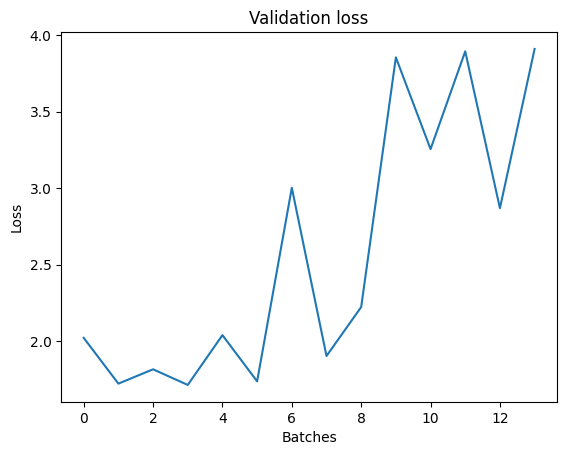

In [41]:
gptTrainer.train(1)

In [42]:
print(gptTrainer.model.my_generate('Что такое питон?'))

Что такое питон? Сгенерируй описание следующего текста, оцени наличие этнического конфликта, наличие позитивного взаимодействия этничностей, мнение о абхаз в тексте, является ли этничность 'абхаз' положительное, этнический конфликт отсутствует.
Текст: А если я не хочу, то мне не надо?
Описание: этот текст является негативным, в текст не является опасной
Задание: если вы не хотите,то не нужно. А вот если вас не хотят - то надо быть жертвой.


In [47]:
for id_, generated in gptTrainer.data[0][0]['generated']:
    print(id_)
    print(generated)
    print("\n-----\n")
    break

9
['Задание: Сгенерируй описание следующего текста, оцени тональность текста, оцени наличие этнического конфликта, наличие позитивного взаимодействия этничностей, мнение о абхаз в тексте, является ли этничность абхаз доминирующей, является ли этничность абхаз агрессором, является ли этничность абхаз опасной.\nТекст: Евгения, в Осетии и миротворческий контингент не помог -его бомбили, в Приднестровье армия РФ только в последний момент после самых тяжелых событий стала разделительной силой,в Абхазии- тоже после отпора грузинам самими абхазцами! Но держаться нужно, не надеясь на скорую помощь.\nОписание: в тексте есть этнический конфликт, в тексте не зафиксировано позитивного взаимодействия этичностей\nЗачем же мне тогда бомбить?\nЯ не бомбила, я не была жертвой, но не является опасной\nа если бы я была опасной, то я бы не стала жертвой\nА вот если вы не боитесь, что я вас бомбит, вы тоже не станете жертвой - то вы можете быть жертвой. А если не хотите - не будете жертвой!\nИ если вас не 

In [43]:
GPTparams = {
    'cut_data': [True, False],
    'batch_size': [10, 20],
    'lr': [1e-5, 1e-6, 1e-4],
    'ngrams': [1, 2, 3, 4, 5]
}

In [44]:
# gptTrainer.choose_model(GPTparams)